In [1]:
# Seed value
SEED = 0

import numpy as np
# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

import tensorflow as tf
# Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)
# Configure a new global `tensorflow` session
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import cv2

# Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED)
 
# Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical, plot_model

In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('No GPU found. Please ensure you have installed TensorFlow correctly')

Default GPU Device: /device:GPU:0


In [5]:
DATA_DIR = r"packages\neural_network_model\neural_network_model\datasets\chest_xray"
TRAIN_DIR = f"{DATA_DIR}\\train"
TEST_DIR = f"{DATA_DIR}\\test"
MODEL_DIR = r"packages\\neural_network_model\\neural_network_model\\trained_models"
DATASETS = [TRAIN_DIR, TEST_DIR]
CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)

NUM_SAMPLES = 10
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224 ,1)
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-3
OPTIMIZER = Adam(LR)
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall')]

In [6]:
def read_image(img_path: str):
    """reading image from path"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_img(img: np.array):
    img = cv2.resize(img, TARGET_SIZE)
    return img

def plot_single_img(img_path: str):
    img = read_image(img_path)
    img = resize_img(img)
    plt.imshow(img, cmap='gray');

In [7]:
imgs_df = []
for dataset in DATASETS:
    for _class in CLASSES:
        imgs_names = os.listdir(f"{dataset}\\{_class}")
        for img_name in imgs_names:
            img_path = f"{dataset}\\{_class}\\" + img_name
            imgs_df.append([img_path, _class])

In [8]:
all_imgs_df = pd.DataFrame(imgs_df)
all_imgs_df.columns = ["path", "label"]
all_imgs_df['target'] = np.where(all_imgs_df['label'].str.contains('PNEUMONIA'), 1, 0)
all_imgs_df = all_imgs_df.sample(frac=1, random_state=SEED)
all_imgs_df.reset_index(drop=True)

,path,label,target
0,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
1,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
2,packages\neural_network_model\neural_network_m...,NORMAL,0
3,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
4,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
...,...,...,...
5851,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
5852,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
5853,packages\neural_network_model\neural_network_m...,PNEUMONIA,1
5854,packages\neural_network_model\neural_network_m...,PNEUMONIA,1


In [9]:
all_imgs_df['label'].value_counts()

PNEUMONIA    4273
NORMAL       1583
Name: label, dtype: int64

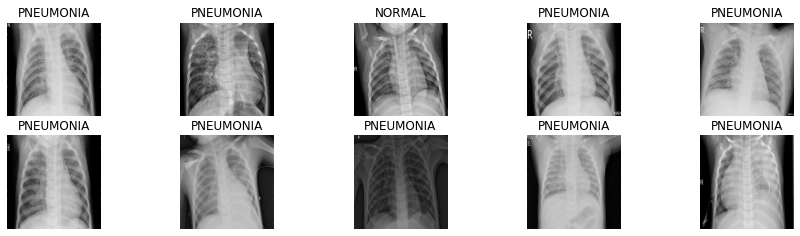

In [10]:
samples = all_imgs_df.sample(n=NUM_SAMPLES)
plt.figure(figsize=(15, 10))
for n in range(NUM_SAMPLES):
    plt.subplot(NUM_SAMPLES//2, NUM_SAMPLES//2, n+1)
    plot_single_img(samples.iloc[n].path)
    plt.title(samples.iloc[n].label)
    plt.axis('off')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(all_imgs_df['path'], all_imgs_df['target'], test_size=0.10, random_state=SEED, shuffle=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
# train_df.path = train_df.path.astype('str')
test_df.path = test_df.path.astype('str')
train_df.target = train_df.target.astype('str')
test_df.target = test_df.target.astype('str')

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255.0,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False, validation_split=0.2)

testgen = ImageDataGenerator(rescale=1./255.0)

In [13]:
train_generator = datagen.flow_from_dataframe(train_df, x_col='path', y_col='target', subset='training', directory=None, batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE, class_mode="binary", color_mode='grayscale', seed=SEED, shuffle=False)
val_generator = datagen.flow_from_dataframe(train_df, x_col='path', y_col='target', subset='validation', directory=None, batch_size=BATCH_SIZE, 
                                             target_size=TARGET_SIZE, class_mode="binary", color_mode='grayscale', seed=SEED, shuffle=False)
test_generator = testgen.flow_from_dataframe(test_df, x_col='path', y_col='target', shuffle=False, batch_size=1,
                                              target_size=TARGET_SIZE, class_mode="binary", color_mode='grayscale', seed=SEED)

Found 4216 validated image filenames belonging to 2 classes.
Found 1054 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


In [17]:
x,y = next(iter(train_generator))
x.shape

(32, 224, 224, 1)

In [24]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = INPUT_SHAPE))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)       

In [15]:
# plot_model(model,  
#            show_layer_names=True, show_shapes=True, rankdir="TB")

In [16]:
model_name = "kaggle_model_weights2.h5"
file_path = f"{MODEL_DIR}\\{model_name}"

model_checkpoint_callback = ModelCheckpoint(file_path, mode='max', monitor='val_accuracy', save_best_only=True, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks = [model_checkpoint_callback, learning_rate_reduction]

In [17]:
%%time
train_steps = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

history = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, epochs=EPOCHS, callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 131 steps, validate for 32 steps
Epoch 1/12
130/131 [============================>.] - ETA: 0s - loss: 0.7101 - accuracy: 0.8273 - precision: 0.8887 - recall: 0.8725
Epoch 00001: val_accuracy improved from -inf to 0.55078, saving model to packages\\neural_network_model\\neural_network_model\\trained_models\kaggle_model_weights2.h5
131/131 [==============================] - 57s 436ms/step - loss: 0.7075 - accuracy: 0.8274 - precision: 0.8890 - recall: 0.8721 - val_loss: 0.7447 - val_accuracy: 0.5508 - val_precision: 0.7189 - val_recall: 0.6429
Epoch 2/12
130/131 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8866 - precision: 0.9311 - recall: 0.9116
Epoch 00002: val_accuracy improved from 0.55078 to 0.73828, saving model to packages\\neural_network_model\\neural_network_model\\trained_models\kaggle_model_weights2.h5
131/131 [==============================] - 54s 414ms/step - loss: 0.3013 - accuracy: 0.8

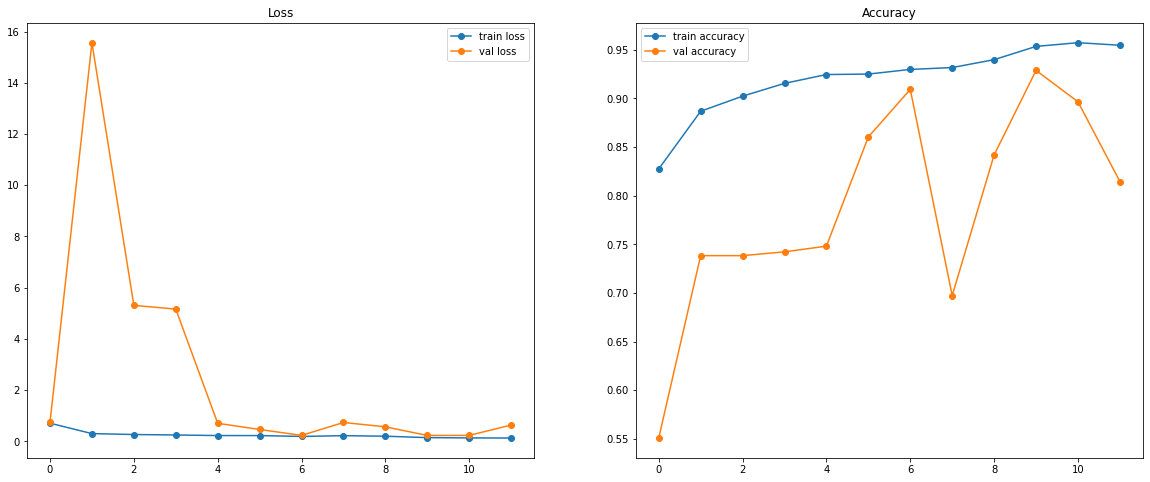

In [18]:
train_loss = history.history['loss']         
train_acc = history.history['accuracy']      
val_loss = history.history['val_loss']       
val_acc = history.history['val_accuracy']    

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)          
plt.plot(epochs_range, train_loss, "-o", label='train loss')   
plt.plot(epochs_range, val_loss, "-o", label='val loss')       
plt.title('Loss')     
plt.legend()          

plt.subplot(1, 2, 2)         
plt.plot(epochs_range, train_acc, "-o", label='train accuracy')    
plt.plot(epochs_range, val_acc, "-o", label='val accuracy')        
plt.title('Accuracy')   
plt.legend()

plt.show();

In [19]:
model = load_model(file_path)
# model

In [20]:
model.evaluate(val_generator, verbose=1,
steps=val_steps)

  ...
    to  
  ['...']
32/32 [==============================] - 10s 324ms/step - loss: 0.2254 - accuracy: 0.9307 - precision: 0.9297 - recall: 0.9802


[0.22537547745741904, 0.93066406, 0.9297365, 0.98015875]

In [21]:
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
preds = (predictions > 0.5).astype("int32")

586/586 [==============================] - 5s 8ms/step


In [22]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       163
           1       0.96      0.93      0.95       423

    accuracy                           0.92       586
   macro avg       0.90      0.92      0.91       586
weighted avg       0.93      0.92      0.92       586



In [23]:
model.evaluate(test_generator, verbose=1)

  ...
    to  
  ['...']
586/586 [==============================] - 5s 8ms/step - loss: 0.1994 - accuracy: 0.9232 - precision: 0.9632 - recall: 0.9291


[0.19935616258227168, 0.9232082, 0.9632353, 0.92907804]